# 2D Code for finite electro-elasticity with u-p formulation.

Problem: Electro-elastic pull-in instability of a 3d VHB  block.

- with basic units:
    - Length: mm
    -  Time:  s
    -   Mass: kg
    - Charge: nC
- and derived units:
    - Pressure: kPa 
    - Force: milliNewtons
    - Electric potential: kV
    
Eric M. Stewart    and    Lallit Anand   
(ericstew@mit.edu)        (anand@mit.edu)   

 October 2023


In [1]:
import numpy as np


from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, FunctionSpace, Expression
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter

import ufl
from ufl import (
    TestFunction,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    tanh,
    as_tensor,
    as_vector,
    ge
)

from dielectricmodels import DE_2D_PE
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters
import random
import gmsh

In [2]:
#
length = 1  # mm
domain = mesh.create_rectangle(MPI.COMM_WORLD,[[0.0,0.0],[length,length]],(10,10),diagonal=mesh.DiagonalType.crossed)
problemName = "DE02_2d_pullin_instability"

In [3]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:59087/index.html?ui=P_0x2a7667390_0&reconnect=auto' style='width: …

In [4]:
#locate different boundaries
#left
tol = 1e-10
def Left(x):
    return np.isclose(x[0], 0)
def Right(x):
    return np.isclose(x[0], length)
def Bottom(x):
    return np.isclose(x[1], 0)
def Top(x):
    return np.isclose(x[1], length)




In [5]:
#Mark boundaries
boundaries = [(1, Left),(2,Bottom),(3,Right),(4,Top)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim-1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)


# Simulation Control

In [6]:
t = 0.0  # start time (s)
rampRate = 1e-1  # s^{-1}
Ttot = 1.0 / rampRate  # total simulation time (s)
numSteps = 100
dt = Constant(domain, Ttot / numSteps)  # (fixed) step size

In [7]:
DE_prob = DE_2D_PE(domain,length= length)
DE_prob.Kinematics()
DE_prob.WeakForms(dt)

In [8]:
DE_prob.phiTot

21.94333646937768

In [9]:
def muAmp(t):
    return float(DE_prob.phiTot)*t/Ttot

In [10]:
Time_cons = Constant(domain,PETSc.ScalarType(muAmp(t)))

#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))


dofs_1 = fem.locate_dofs_topological(DE_prob.ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
dofs_2 = fem.locate_dofs_topological(DE_prob.ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(2))

dofs_3 = fem.locate_dofs_topological(DE_prob.ME.sub(2), facet_tag.dim, facet_tag.find(2))
dofs_4 = fem.locate_dofs_topological(DE_prob.ME.sub(2), facet_tag.dim, facet_tag.find(4))



bcs_1 = dirichletbc(0.0, dofs_1,DE_prob.ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, dofs_2, DE_prob.ME.sub(0).sub(1))  # u2 fix - yBot

bcs_3 = dirichletbc(0.0, dofs_3, DE_prob.ME.sub(2))  # u2 fix - yBot
bcs_4 = dirichletbc(Time_cons,dofs_4 ,DE_prob.ME.sub(2))  # u3 fix - zBot

#
bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

# Set Output File

In [11]:
import dolfinx
U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, DE_prob.P1)#Scalar function space

u_vis = Function(V2)
u_vis.name = "u"
u_expr = Expression(DE_prob.u,V2.element.interpolation_points())


p_vis = Function(V1)
p_vis.name = "p"
p_expr = Expression(DE_prob.p,V1.element.interpolation_points())

phi_Vis = Function(V1)
phi_Vis.name = "phi"
phi_expr = Expression(DE_prob.phi,V1.element.interpolation_points())


T = DE_prob.Tmat *DE_prob.F.T/DE_prob.J#Cauchy Stress

T0 = T - (1 / 3) * tr(T) * Identity(3)
Mises = sqrt((3 / 2) * inner(T0, T0))




Mises_vis = Function(V1)
Mises_vis.name = "Mises"
mises_expr = Expression(Mises,V1.element.interpolation_points())

#vtk2 = VTXWriter(domain.comm,"results/"+problemName+"displacement.bp", [u_vis], engine="BP4" )

vtk = VTXWriter(domain.comm,"results/"+problemName+".bp", [u_vis,p_vis,phi_Vis,Mises_vis], engine="BP4" )

files = [vtk]

def interp_and_save(t, files: list[VTXWriter]):
    u_vis.interpolate(u_expr)
    p_vis.interpolate(p_expr)
    phi_Vis.interpolate(phi_expr)
    Mises_vis.interpolate(mises_expr)

    for file in files:
        file.write(t)


pointForStress = [length,length,0]
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForStress)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForStress)
 

In [12]:
import os
step = "Swell"
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}

problem = NonlinearProblem(DE_prob.Res,DE_prob.w, bcs, DE_prob.a,jit_options=jit_options)

totSteps = numSteps + 1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])

solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 30
solver.report = True
solver.error_on_nonconvergence = False

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_max_it"] = 30
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

startTime = datetime.now()
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

step = "Actuate"

#if os.path.exists("results/"+problemName+".bp"):
#    os.remove("results/"+problemName+".xdmf")
#    os.remove("results/"+problemName+".h5")

#vtk.write_mesh(domain)
t = 0.0
#log.set_log_level(log.LogLevel.INFO)
interp_and_save(t, files)
ii = 0
bisection_count = 0
totSteps = numSteps + 1

timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])

while round(t + dt, 9) <= Ttot:
    # increment time
    t += float(dt) 
    # increment counter
    ii +=1
    Time_cons.value = muAmp(t)
    

    # Solve the problem
    
    (iter, converged) = solver.solve(DE_prob.w)
    
    if converged:
        DE_prob.w.x.scatter_forward()
        DE_prob.w_old.x.array[:] = DE_prob.w.x.array
        
        timeHist0[ii] = DE_prob.w.sub(0).sub(1).eval(pointForStress,colliding_cells[0])[0]
        timeHist1[ii] = DE_prob.w.sub(2).eval(pointForStress,colliding_cells[0])[0]  # time history of voltage phi
        
        interp_and_save(t, files)
        
        if ii % 1 == 0:
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
           
            
            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print(f"Simulation Time: {t:.2f} s | dt: {float(dt):.4f}s")
            print()
        #Reset Biseciton Counter
        bisection_count = 0
        
    else:
        
        print( "Error Halfing Time Step")
        break
        

#End Analysis

for file in files:
    file.close()
endTime = datetime.now()
print("------------------------------------")
print("Simulation End")
print("------------------------------------")
print("Total Time: {}".format(endTime - startTime))
print("------------------------------------")

------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 4
Simulation Time: 0.10 s | dt: 0.1000s

Step: Actuate |   Increment: 2 | Iterations: 4
Simulation Time: 0.20 s | dt: 0.1000s

Step: Actuate |   Increment: 3 | Iterations: 4
Simulation Time: 0.30 s | dt: 0.1000s

Step: Actuate |   Increment: 4 | Iterations: 4
Simulation Time: 0.40 s | dt: 0.1000s

Step: Actuate |   Increment: 5 | Iterations: 4
Simulation Time: 0.50 s | dt: 0.1000s

Step: Actuate |   Increment: 6 | Iterations: 4
Simulation Time: 0.60 s | dt: 0.1000s

Step: Actuate |   Increment: 7 | Iterations: 4
Simulation Time: 0.70 s | dt: 0.1000s

Step: Actuate |   Increment: 8 | Iterations: 4
Simulation Time: 0.80 s | dt: 0.1000s

Step: Actuate |   Increment: 9 | Iterations: 4
Simulation Time: 0.90 s | dt: 0.1000s

Step: Actuate |   Increment: 10 | Iterations: 4
Simulation Time: 1.00 s | dt: 0.1000s

Step: Actuate |   Increment: 11 | Iterations: 4


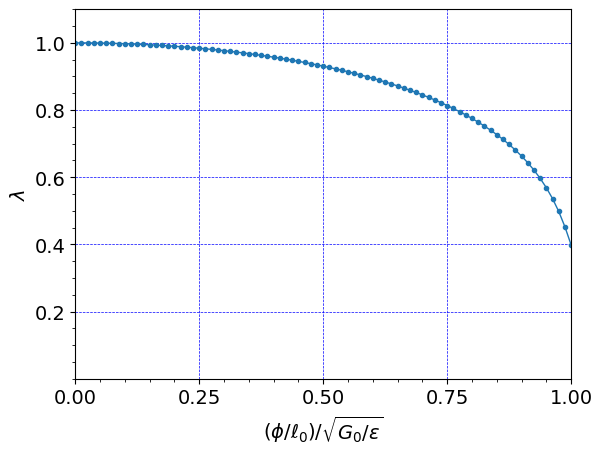

<Figure size 600x400 with 0 Axes>

In [13]:
"""""" """""" """""" """
    VISUALIZATION
""" """""" """""" """"""
import matplotlib.pyplot as plt

# set plot font to size 14
font = {"size": 14}
plt.rc("font", **font)

# Get array of default plot colors
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus stretch in the vertical direction.
#
normVolts = timeHist1 / (length * np.sqrt(float(DE_prob.Geq_0) / float(DE_prob.vareps)))
normVolts = normVolts[0:ii]
#
stretch = timeHist0 / length + 1.0
stretch = stretch[0:ii]
#
plt.plot(normVolts, stretch, c=colors[0], linewidth=1.0, marker=".")
# plt.scatter(normVolts[ii-1], stretch[ii-1], c='k', marker='x', s=100)
# plt.scatter(normVolts[ii-1], stretch[ii-1], c='k',  s=100)
plt.grid(linestyle="--", linewidth=0.5, color="b")
ax = plt.gca()
#
ax.set_ylabel(r"$\lambda$")
ax.set_ylim([0.0, 1.1])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
#
ax.set_xlabel(r"$(\phi/\ell_0)/\sqrt{G_0/\varepsilon} $")
ax.set_xlim([0.2, 1.0])
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
#
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()

fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout()
plt.savefig("results/"+problemName+".png", dpi=600)